# 🌊 Machine Learning & Deep Learning for Microbiome and Multi-omics Data
### Training Hands-on Session
**Date:** _2025-10-21_  
**Author:** _Berkay Ekren_  
**Session:** Hands-On

##### ⚙️ Required Tools-Modules
1. Python >= 3.12
2. pandas
3. numpy
4. seaborn
5. matplotlib
6. scikit-learn
7. boruta
8. xgboost
9. lightgbm
10. tensorflow
11. keras (part of tensorflow)


### 📄 Data import for Hands-on Sessions

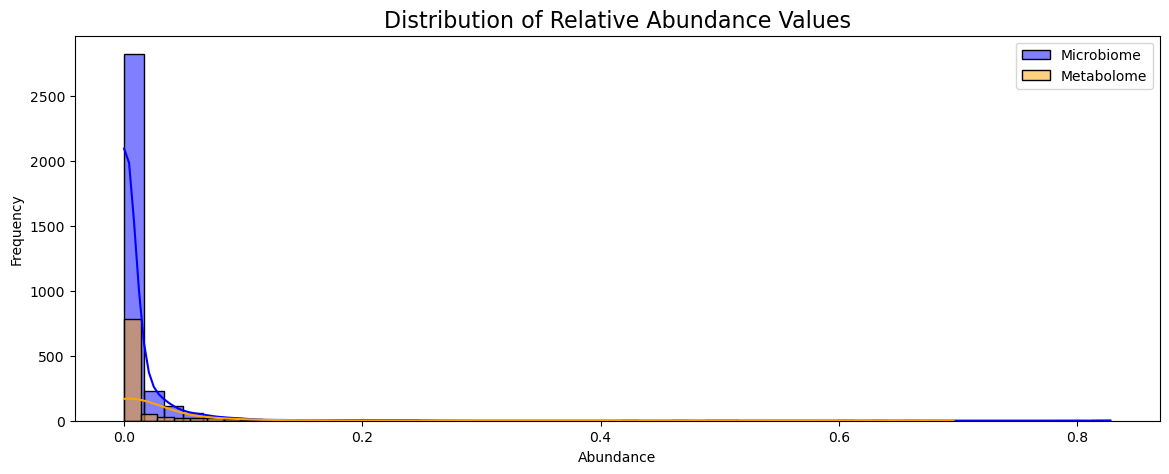

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the medatada
metadata_df = pd.read_csv("data/metadata.csv", sep="\t")

# Import data [1]
microbiome_df = pd.read_csv("data/microbiome.csv", sep="\t")
metabolome_df = pd.read_csv("data/metabolome.csv", sep="\t")

# Uncomment the below 2 lines to see the first few rows of the dataframes to see the file structure
#print(microbiome_df.head())
#print(metabolome_df.head())

# Check the distribution of the data with histograms
plt.figure(figsize=(14, 5))
sns.histplot(microbiome_df.iloc[:, 1:].values.flatten(), bins=50, color='blue', label='Microbiome', kde=True)
sns.histplot(metabolome_df.iloc[:, 1:].values.flatten(), bins=50, color='orange', label='Metabolome', kde=True)
plt.title('Distribution of Relative Abundance Values', fontsize=16)
plt.xlabel('Abundance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 🕐 Hands-on Session 1: Machine Learning for Microbiome and Multi-omics Case Studies
### 📋 Objectives:
- Perform **classification** or **regression** using microbiome and omics datasets.
- Identify **biomarkers** relevant to aquaculture species.

### 🔗 Suggested Datasets:
- Microbiome OTU/ASV tables
- Metabolomics or transcriptomics profiles
- Aquaculture phenotype or environmental metadata

### 🧰 Tasks:
1. Load and preprocess data
2. Explore dataset (summary statistics, visualization)
3. Early integration - Late integration methods
4. Apply ML models (e.g., Random Forest, SVM, Gradient Boosting)
5. Evaluate model performances
6. Identify potential biomarkers (feature importance, SHAP, etc.)

In [13]:
# Import necessary libraries, uncomment as needed for regression tasks
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV, StratifiedKFold #, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier #, RandomForestRegressor
from sklearn.svm import SVC #, SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay
# from sklearn.metrics import mean_squared_error, r2_score

#### 🧬 Early integration in machine learning: Concatanate features before modelling

In [ ]:
print("--- Strategy 1: Early Integration ---")

# 1. Set the first column as the index for each dataframe
microbiome_features = microbiome_df.set_index(microbiome_df.columns[0])
metabolome_features = metabolome_df.set_index(metabolome_df.columns[0])

# 2. Transpose the dataframes so that rows are samples and columns are features
X_microbiome = microbiome_features.T
X_metabolome = metabolome_features.T

# 3. Concatenate the dataframes horizontally (axis=1) to create a single feature matrix.
# This aligns the data by sample ID (the index).
early_integration_df = pd.concat([X_microbiome, X_metabolome], axis=1)

print("Shape of Microbiome data (samples, features):", X_microbiome.shape)
print("Shape of Metabolome data (samples, features):", X_metabolome.shape)
print("Shape of combined data for Early Integration:", early_integration_df.shape)

print("\n Early Integration DataFrame Head ")
print(early_integration_df.head(2))

# Create target variables (y) from metadata 
# 4. Set the first column (sample IDs) as the index of the metadata
metadata_indexed = metadata_df.set_index(metadata_df.columns[0])

# 5. Align metadata with the feature dataframe to ensure correct sample order
aligned_metadata = metadata_indexed.reindex(early_integration_df.index)

# 6. Create the classification target from the 'sampling_site' column
# We use factorize to convert site names (e.g., 'SiteA', 'SiteB') into numbers (0, 1)
y_classification, class_labels = pd.factorize(aligned_metadata[aligned_metadata.columns[1]])
print(f"\nClassification target created from column: '{aligned_metadata.columns[1 ]}'")
print(f"Classes found: {class_labels.tolist()}")

--- Strategy 1: Early Integration ---
Shape of Microbiome data (samples, features): (35, 95)
Shape of Metabolome data (samples, features): (35, 29)
Shape of combined data for Early Integration: (35, 124)

--- Early Integration DataFrame Head ---
        Actinomarinales  Alteromonadales  Babeliales  Bacteroidales  \
GF_CC1              0.0              0.0         0.0            0.0   
GF_CC2              0.0              0.0         0.0            0.0   

        Balneolales  Bdellovibrionales  Betaproteobacteriales  Caldilineales  \
GF_CC1     0.000284           0.005826               0.735152            0.0   
GF_CC2     0.000142           0.004831               0.346547            0.0   

        Campylobacterales  Cellvibrionales  ...  Phosphatidylserines  \
GF_CC1                0.0         0.001137  ...             0.000000   
GF_CC2                0.0         0.000710  ...             0.001111   

        Simple_Glc_series  Sitosterol_Esters  Sphingomyelins  Sphingosines  \
GF_C

##### Split the data into training and testing sets

In [ ]:
# Split the data into training and testing sets
print("\n--- Data splitting for testing and training... ---")


# For regression, we'll use the factorized labels as a placeholder. In practice, replace this with a real continuous variable.
y_regression = y_classification

# Split data for classification task
X_train_early_c, X_test_early_c, y_train_c, y_test_c = train_test_split(
    early_integration_df, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)
# Split data for regression task
X_train_early_r, X_test_early_r, y_train_r, y_test_r = train_test_split(
    early_integration_df, y_regression, test_size=0.2, random_state=42
)

# Display the shapes of the resulting datasets
print("\nShapes of the datasets after splitting:")
print("Classification Task:")
print("X_train_early_c:", X_train_early_c.shape, "X_test_early_c:", X_test_early_c.shape)
print("y_train_c:", y_train_c.shape, "y_test_c:", y_test_c.shape)
print("\nRegression Task:")
print("X_train_early_r:", X_train_early_r.shape, "X_test_early_r:", X_test_early_r.shape)
print("y_train_r:", y_train_r.shape, "y_test_r:", y_test_r.shape)

print("\nData successfully split for training and testing.")


Data splitting for testing and training...

Shapes of the datasets after splitting:
Classification Task:
X_train_early_c: (28, 124) X_test_early_c: (7, 124)
y_train_c: (28,) y_test_c: (7,)

Regression Task:
X_train_early_r: (28, 124) X_test_early_r: (7, 124)
y_train_r: (28,) y_test_r: (7,)

Data successfully split for training and testing.


##### Random Forest Importance dependent feature selection

In [ ]:
# Random Forest Importance dependent feature selection
print("\n--- Feature Selection using Random Forest Importance ---")

# 1. Define the base estimator for feature selection
# We use a RandomForestClassifier, as its feature_importances_ attribute is what we need.
# Using class_weight='balanced' is good practice for potentially imbalanced datasets.
rf_for_selection = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

# 2. Use SelectFromModel to automatically select features
# This transformer selects features based on an importance threshold.
# By default, it uses the median importance as the threshold, which is a good starting point.
feature_selector = SelectFromModel(estimator=rf_for_selection)

# 3. Fit the selector on the original (pre-Boruta) training data
print("Fitting the feature selector on the training data...")
# We use the 'early_integration' data before any feature selection was applied
feature_selector.fit(X_train_early_c, y_train_c)

# 4. Get the boolean mask of selected features
selected_features_mask_rf = feature_selector.get_support()

# 5. Apply the mask to get the new feature DataFrames
X_train_selected_c = X_train_early_c.loc[:, selected_features_mask_rf]
X_test_selected_c = X_test_early_c.loc[:, selected_features_mask_rf]

# 6. Display the results
print(f"\nOriginal number of features: {X_train_early_c.shape[1]}")
print(f"Number of features selected by Random Forest: {X_train_selected_c.shape[1]}")

print("\nNames of the first 10 selected features:")
print(X_train_selected_c.columns[:10].tolist())


 Feature Selection using Random Forest Importance
Fitting the feature selector on the training data...

Original number of features: 124
Number of features selected by Random Forest: 46

Names of the first 10 selected features:
['Bdellovibrionales', 'Betaproteobacteriales', 'Caldilineales', 'Class_Alphaproteobacteria', 'Class_Gammaproteobacteria', 'Class_P9X2b3D02', 'Class_Subgroup 11', 'Class_Subgroup 6', 'Class_Subgroup 9', 'Class_TK17']


In [ ]:
# Feature Selection using Boruta
print ("\n--- Feature Selection using Boruta ---")

# 1. Define the estimator
# Boruta needs a base estimator that provides feature importances. Random Forest is perfect.
rf_for_boruta = RandomForestClassifier(n_jobs=-1,class_weight='balanced',max_depth=5,random_state=42)

# 2. Define Boruta feature selection method
# n_estimators='auto' will let Boruta decide the number of trees and set verbose to 2 to see the progress
boruta_selector = BorutaPy(estimator=rf_for_boruta,n_estimators='auto',verbose=2, random_state=42)

# 3. Find all relevant features
# Boruta expects numpy arrays, so we use .values
# Note: Boruta can be slow on datasets with many features.
boruta_selector.fit(X_train_early_c.values, y_train_c)

# 4. Select the confirmed AND tentative important features
# With small datasets, it's often useful to include tentative features.
selected_features_mask = boruta_selector.support_ | boruta_selector.support_weak_

X_train_selected_c = X_train_early_c.loc[:, selected_features_mask]
X_test_selected_c = X_test_early_c.loc[:, selected_features_mask]

# For the regression task, we'll use the same selected features for consistency
X_train_selected_r = X_train_early_r.loc[:, selected_features_mask]
X_test_selected_r = X_test_early_r.loc[:, selected_features_mask]

print(f"\nOriginal number of features: {X_train_early_c.shape[1]}")
print(f"Number of features selected by Boruta (Confirmed + Tentative): {X_train_selected_c.shape[1]}")



--- Finding Best Model and Hyperparameters with GridSearchCV ---

--- Tuning LogisticRegression ---
Best parameters for LogisticRegression: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best cross-validated AUC score: 0.5000
Best parameters for LogisticRegression: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best cross-validated AUC score: 0.5000


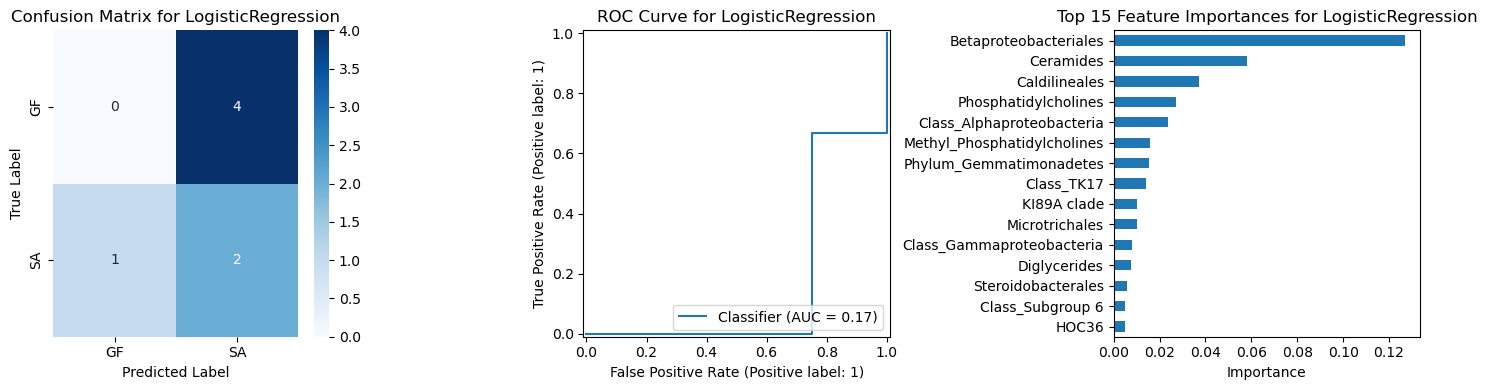


--- Tuning RandomForestClassifier ---
Best parameters for RandomForestClassifier: {'class_weight': 'balanced', 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 150}
Best cross-validated AUC score: 0.6458
Best parameters for RandomForestClassifier: {'class_weight': 'balanced', 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 150}
Best cross-validated AUC score: 0.6458


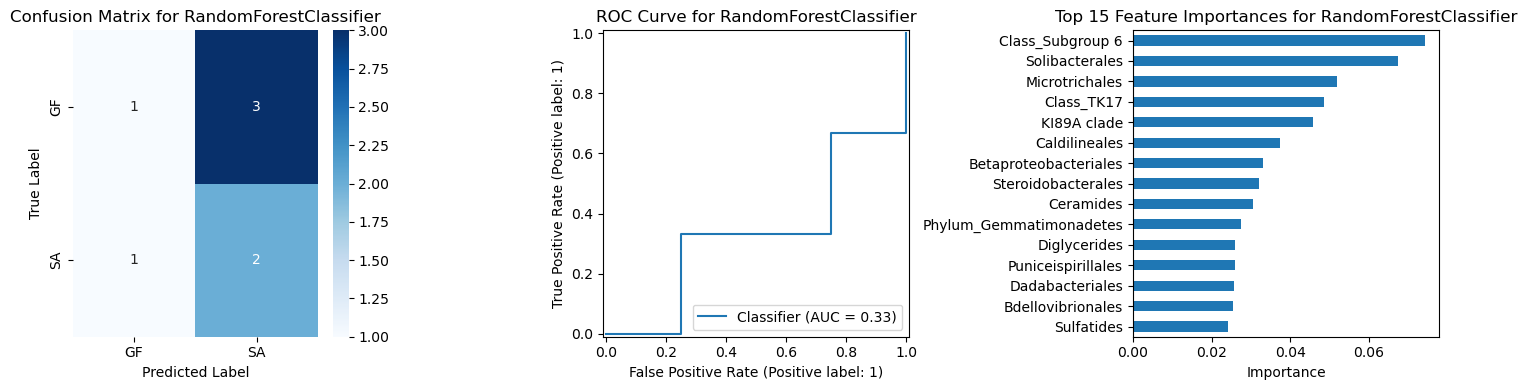


--- Tuning SVC ---
Best parameters for SVC: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validated AUC score: 0.5833


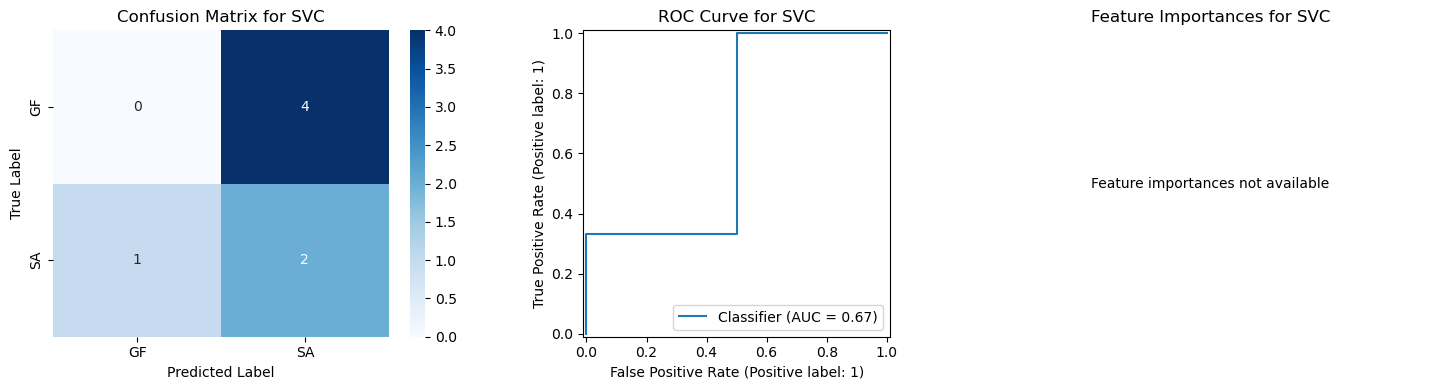


--- Tuning LightGBM ---
Best parameters for LightGBM: {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 2, 'n_estimators': 75, 'num_leaves': 7}
Best cross-validated AUC score: 0.6146
Best parameters for LightGBM: {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 2, 'n_estimators': 75, 'num_leaves': 7}
Best cross-validated AUC score: 0.6146


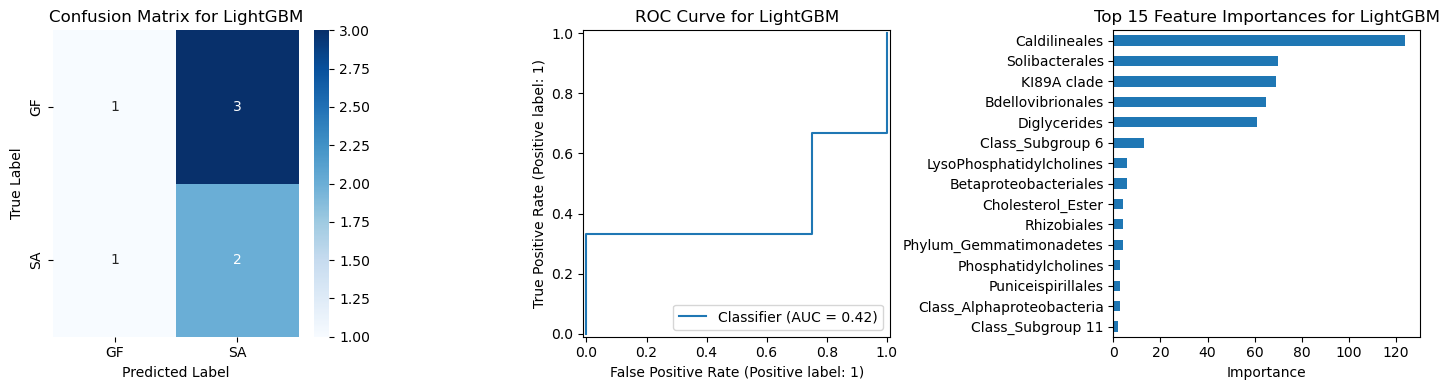


--- Tuning XGBoost ---
Best parameters for XGBoost: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
Best cross-validated AUC score: 0.7917
Best parameters for XGBoost: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
Best cross-validated AUC score: 0.7917


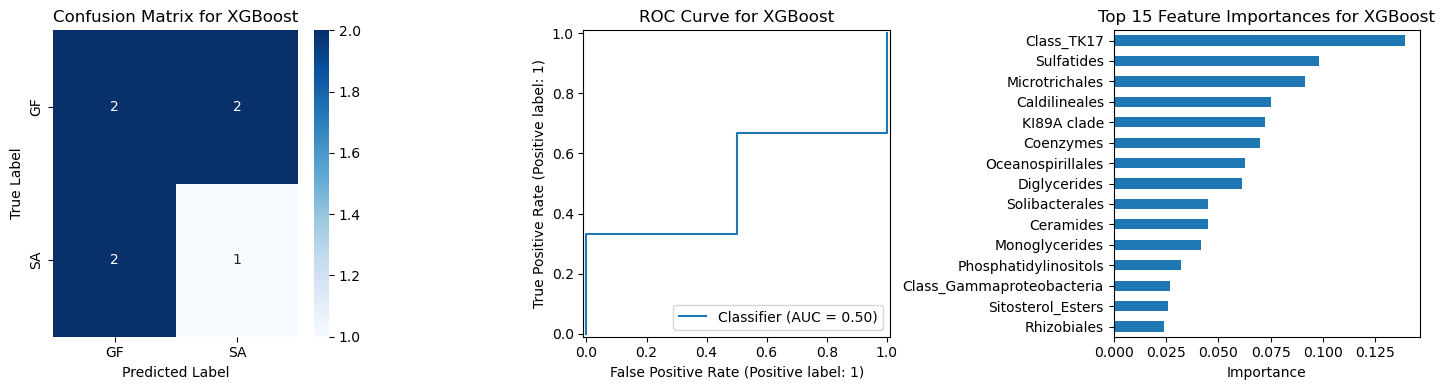


--- Champion Model: XGBoost ---
Best CV AUC: 0.7917

Performance of Champion Model on Test Set:
  Accuracy: 0.4286
  AUC: 0.5000

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.33      0.33      0.33         3

    accuracy                           0.43         7
   macro avg       0.42      0.42      0.42         7
weighted avg       0.43      0.43      0.43         7



In [ ]:
# Models for Classification (Early Integration)
# Hyperparameter Tuning with Cross-Validation for Multiple Models 
print("\n--- Finding Best Model and Hyperparameters with GridSearchCV ---")

# Define the models and their parameter grids
# Calculate scale_pos_weight for imbalanced datasets
scale_pos_weight_value = (len(y_train_c) - sum(y_train_c)) / sum(y_train_c)
y_train_c = y_train_c.astype(int)
y_test_c = y_test_c.astype(int)

# Models for the main loop (XGBoost is now excluded)
models = {
    'LogisticRegression': LogisticRegression(random_state=42,
                                             max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42,
               probability=True),
    'LightGBM': lgb.LGBMClassifier(random_state=42,
                                   verbose=-1), # verbose=-1 silences LGBM warnings
    'XGBoost': xgb.XGBClassifier(base_score=np.sum(y_train_c == 0)/len(y_train_c),
                                 objective='binary:logistic',
                                 booster='gbtree',
                                 tree_method='hist',
                                 random_state=42,
                                 scale_pos_weight=scale_pos_weight_value)
}

param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [1, 3],
        'class_weight': ['balanced']
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 50, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
        'class_weight': ['balanced']
    },
    'LightGBM': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'class_weight': ['balanced'],
        'num_leaves': [7, 15, 31],
        'min_child_samples': [1, 2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 75, 100, 150],
        'learning_rate': [0.001, 0.01, 0.1, 0.5],
        'gamma': [0, 0.1, 0.5],
        'max_depth': [3, 5],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0]
    }
}

# Set up the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

best_score = -1
best_model_name = ""
best_estimator = None

# Loop through the models
for name, model in models.items():
    print(f"\n Tuning {name} ")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=0)
    grid_search.fit(X_train_selected_c, y_train_c)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validated AUC score: {grid_search.best_score_:.4f}")
        
    best_model = grid_search.best_estimator_
    y_pred_final = best_model.predict(X_test_selected_c)
    y_proba_final = best_model.predict_proba(X_test_selected_c)[:, 1]
    
    # Plot Confusion Matrix, AUROC, and Feature Importance Side-by-Side
    fig, axes = plt.subplots(1, 3, figsize=(14.4, 4))

    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_test_c, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix for {name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Plot 2: ROC Curve
    RocCurveDisplay.from_predictions(y_test_c, y_proba_final, ax=axes[1])
    axes[1].set_title(f'ROC Curve for {name}')
    
    # Plot 3: Feature Importance
    importances = None
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = best_model.coef_[0]

    if importances is not None:
        feature_names = X_train_selected_c.columns
        forest_importances = pd.Series(importances, index=feature_names)
        top_importances = forest_importances.abs().nlargest(15)
        
        top_importances.sort_values(ascending=True).plot.barh(ax=axes[2])
        axes[2].set_title(f'Top 15 Feature Importances for {name}')
        axes[2].set_xlabel('Importance')
    else:
        axes[2].text(0.5, 0.5, 'Feature importances not available', ha='center', va='center')
        axes[2].set_title(f'Feature Importances for {name}')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = name
        best_estimator = grid_search.best_estimator_

# Evaluate the Overall Best Model Found
if best_estimator is not None:
    print(f"\n Champion Model: {best_model_name} ")
    print(f"Best CV AUC: {best_score:.4f}")

    # Evaluate the final, champion model on the held-out test set
    y_pred_final = best_estimator.predict(X_test_selected_c)
    y_proba_final = best_estimator.predict_proba(X_test_selected_c)[:, 1]

    final_accuracy = accuracy_score(y_test_c, y_pred_final)
    final_auc = roc_auc_score(y_test_c, y_proba_final)

    print("\nPerformance of Champion Model on Test Set:")
    print(f"  Accuracy: {final_accuracy:.4f}")
    print(f"  AUC: {final_auc:.4f}")

    print("\nClassification Report on Test Set:")
    print(classification_report(y_test_c, y_pred_final))

else:
    print("\nCould not determine a best model due to errors during tuning.")

#### 🧬 Late Integration: Train models separately, then combine predictions (Decision-Level)

In [ ]:
print("\n--- Strategy 2: Late Integration Data Splitting ---")

# Create training and test dataframes for microbiome and metabolome raw data
microbiome_features = microbiome_df.set_index(microbiome_df.columns[0])
metabolome_features = metabolome_df.set_index(metabolome_df.columns[0])

# Transpose the dataframes so that rows are samples and columns are features
X_microbiome = microbiome_features.T
X_metabolome = metabolome_features.T

# Create target variables (y) from metadata
metadata_indexed = metadata_df.set_index(metadata_df.columns[0])

# Align metadata with the feature dataframe to ensure correct sample order
aligned_metadata = metadata_indexed.reindex(X_microbiome.index)

# Create the classification target from the 'sampling_site' column
y_classification, class_labels = pd.factorize(aligned_metadata[aligned_metadata.columns[1]])
print(f"\nClassification target created from column: '{aligned_metadata.columns[1 ]}'")
print(f"Classes found: {class_labels.tolist()}")

# Split microbiome data
X_micro_train, X_micro_test, y_train_late, y_test_late = train_test_split(
    X_microbiome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Split metabolome data using the same indices from the first split
# We can achieve this by splitting the metabolome data with the same parameters.
X_metab_train, X_metab_test, _, _ = train_test_split(
    X_metabolome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Display the shapes of the resulting datasets
print("\n Shapes of the datasets for Late Integration ")
print("Microbiome Data:")
print("X_micro_train:", X_micro_train.shape, "| X_micro_test:", X_micro_test.shape)
print("\nMetabolome Data:")
print("X_metab_train:", X_metab_train.shape, "| X_metab_test:", X_metab_test.shape)
print("\nTarget Variable:")
print("y_train_late:", y_train_late.shape, "| y_test_late:", y_test_late.shape)

print("\nData successfully split for late integration.")


In [ ]:
# Apply feature selection with Random Forest Importance for Late Integration datasets
print("\n--- Feature Selection using Random Forest Importance for Late Integration ---")

# Define a function to run RF-based feature selection, as we'll do it for each dataset
def run_rf_selection(X_train, y_train, data_name=""):
    print(f"\nStarting Random Forest feature selection for {data_name} data...")
    # 1. Define the base estimator
    rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    
    # 2. Use SelectFromModel to automatically select features based on median importance
    feature_selector = SelectFromModel(estimator=rf_estimator, threshold='median')
    
    # 3. Fit the selector on the training data
    feature_selector.fit(X_train, y_train)
    
    # 4. Get the boolean mask of selected features
    selected_mask = feature_selector.get_support()
    
    print(f"Random Forest selected {sum(selected_mask)} features from {X_train.shape[1]} for {data_name} data.")
    
    return selected_mask

# Run RF Selection on Microbiome Data
rf_mask_micro = run_rf_selection(X_micro_train, y_train_late, "Microbiome")
X_micro_train_selected = X_micro_train.loc[:, rf_mask_micro]
X_micro_test_selected = X_micro_test.loc[:, rf_mask_micro]

# Run RF Selection on Metabolome Data
rf_mask_metab = run_rf_selection(X_metab_train, y_train_late, "Metabolome")
X_metab_train_selected = X_metab_train.loc[:, rf_mask_metab]
X_metab_test_selected = X_metab_test.loc[:, rf_mask_metab]

print("\n Shapes after Random Forest Feature Selection ")
print("Microbiome Train:", X_micro_train_selected.shape, "| Microbiome Test:", X_micro_test_selected.shape)
print("Metabolome Train:", X_metab_train_selected.shape, "| Metabolome Test:", X_metab_test_selected.shape)


In [ ]:
# Apply feature selection with Boruta for Late Integration datasets
print("\n--- Feature Selection using Boruta for Late Integration ---")

# Define a function to run Boruta, as we'll do it for each dataset
def run_boruta_selection(X_train, y_train, data_name=""):
    print(f"\nStarting Boruta for {data_name} data...")
    # Define the estimator
    rf_estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
    
    # Define Boruta feature selection method
    boruta_selector = BorutaPy(
        estimator=rf_estimator,
        n_estimators='auto',
        verbose=0, # Set to 2 to see progress
        random_state=42
    )
    
    # Find all relevant features
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the mask for selected features (confirmed + tentative)
    selected_mask = boruta_selector.support_ | boruta_selector.support_weak_
    
    print(f"Boruta selected {sum(selected_mask)} features from {X_train.shape[1]} for {data_name} data.")
    
    return selected_mask

# Run Boruta on Microbiome Data
boruta_mask_micro = run_boruta_selection(X_micro_train, y_train_late, "Microbiome")
X_micro_train_selected = X_micro_train.loc[:, boruta_mask_micro]
X_micro_test_selected = X_micro_test.loc[:, boruta_mask_micro]

# Run Boruta on Metabolome Data
boruta_mask_metab = run_boruta_selection(X_metab_train, y_train_late, "Metabolome")
X_metab_train_selected = X_metab_train.loc[:, boruta_mask_metab]
X_metab_test_selected = X_metab_test.loc[:, boruta_mask_metab]

print("\n Shapes after Boruta Feature Selection ")
print("Microbiome Train:", X_micro_train_selected.shape, "| Microbiome Test:", X_micro_test_selected.shape)
print("Metabolome Train:", X_metab_train_selected.shape, "| Metabolome Test:", X_metab_test_selected.shape)

# The selected dataframes (e.g., X_micro_train_selected) are now ready for the next step.



--- Feature Selection using Boruta for Late Integration ---


NameError: name 'X_micro_train' is not defined

In [ ]:
# Strategy 2: Late Integration (Decision-Level) with Feature-Selected Data
print("\n--- Late Integration (Decision-Level) with Feature-Selected Data and GridSearchCV ---")

# We will use the data selected by Boruta. To use RF-selected data, change the dictionaries below.
datasets_train = {'micro': X_micro_train_selected, 'metab': X_metab_train_selected}
datasets_test = {'micro': X_micro_test_selected, 'metab': X_metab_test_selected}

scale_pos_weight_value = (len(y_train_late) - sum(y_train_late)) / sum(y_train_late)

# Define the base models to be used for each dataset
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000,
                                             random_state=42),
    'SVC': SVC(probability=True,
               random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42,
                                   verbose=-1),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic',
                                 booster='gbtree',
                                 tree_method='hist',
                                 random_state=42)
}

param_grids_late = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [1, 3],
        'class_weight': ['balanced']
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 50, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
        'class_weight': ['balanced']
    },
    'LightGBM': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'class_weight': ['balanced'],
        'num_leaves': [7, 15, 31],
        'min_child_samples': [1, 2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 75, 100, 150],
        'learning_rate': [0.001, 0.01, 0.1, 0.5],
        'gamma': [0, 0.1, 0.5],
        'max_depth': [3, 5],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0]
    }
}

meta_features_train = []
meta_features_test = []
model_performance = {}

# Set up the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Train base models with GridSearchCV, evaluate them, and generate predictions for the meta-model
for name, model in base_models.items():
    print(f"\n Evaluating Base Model: {name} ")
    for data_type, X_train_curr in datasets_train.items():
        print(f"Tuning and training on {data_type} data...")
        
        X_test_curr = datasets_test[data_type]
        
        # Tune hyperparameters for the base model
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids_late[name], cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=0)
        grid_search.fit(X_train_curr, y_train_late)
        best_model = grid_search.best_estimator_
        
        print(f"  Best params for {name} on {data_type}: {grid_search.best_params_}")
        
        # Fit the best model on the full training data to evaluate it
        best_model.fit(X_train_curr, y_train_late)
        y_proba = best_model.predict_proba(X_test_curr)[:, 1]
        
        # Evaluate and store performance
        auc = roc_auc_score(y_test_late, y_proba)
        model_performance[f"{name}_{data_type}"] = auc
        print(f"  AUC for {name} on {data_type}: {auc:.4f}")

        # Plot Feature Importance for the base model
        fig, ax = plt.subplots(1, 1, figsize=(7.2, 4))
        importances = None
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
        elif hasattr(best_model, 'coef_'):
            importances = best_model.coef_[0]

        if importances is not None:
            feature_names = X_train_curr.columns
            base_importances = pd.Series(importances, index=feature_names)
            top_importances = base_importances.abs().nlargest(15)
            
            top_importances.sort_values(ascending=True).plot.barh(ax=ax)
            ax.set_title(f'Top 15 Feature Importances for {name} on {data_type}')
            ax.set_xlabel('Importance')
        else:
            ax.text(0.5, 0.5, 'Feature importances not available', ha='center', va='center')
            ax.set_title(f'Feature Importances for {name} on {data_type}')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

        # Generate cross-validated predictions for the training set (for meta-model)
        train_preds = cross_val_predict(best_model, X_train_curr, y_train_late, cv=cv_strategy, method='predict_proba')[:, 1]
        meta_features_train.append(train_preds)
        
        # Predict on the test set for the meta-model
        meta_features_test.append(y_proba)

# Identify the best-performing base model
best_base_model_key = max(model_performance, key=model_performance.get)
print(f"\n Best Performing Base Model Combination: {best_base_model_key} (AUC: {model_performance[best_base_model_key]:.4f}) ")

# Combine predictions into final meta-feature matrices
X_late_train = np.array(meta_features_train).T
X_late_test = np.array(meta_features_test).T

print(f"\nShape of the new feature set for the meta-model (train): {X_late_train.shape}")
print(f"Shape of the new feature set for the meta-model (test): {X_late_test.shape}")

# Train and evaluate the final meta-models using all base model types with GridSearchCV
print("\n Training and evaluating the final meta-models with GridSearchCV ")
meta_feature_names = [f"{name}_{data_type}" for name in base_models.keys() for data_type in datasets_train.keys()]

for name, model in base_models.items():
    print(f"\n Meta-Model: {name} ")
    
    # Tune the meta-model
    meta_grid_search = GridSearchCV(estimator=model, param_grid=param_grids_late[name], cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=0)
    meta_grid_search.fit(X_late_train, y_train_late)
    best_meta_model = meta_grid_search.best_estimator_
    
    print(f"  Best params for {name} meta-model: {meta_grid_search.best_params_}")

    y_pred_meta = best_meta_model.predict(X_late_test)
    y_proba_meta = best_meta_model.predict_proba(X_late_test)[:, 1]

    accuracy_meta = accuracy_score(y_test_late, y_pred_meta)
    auc_meta = roc_auc_score(y_test_late, y_proba_meta)

    print("\n Performance of Late Integration (Decision-Level) Model ")
    print(f"  Accuracy: {accuracy_meta:.4f}")
    print(f"  AUC: {auc_meta:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test_late, y_pred_meta, target_names=class_labels, zero_division=0))

    # Plot confusion matrix, AUROC, and Feature Importance for the final meta-model
    fig, axes = plt.subplots(1, 3, figsize=(14.4, 4))

    # Confusion Matrix
    cm_meta = confusion_matrix(y_test_late, y_pred_meta)
    sns.heatmap(cm_meta, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix for {name} Meta-Model')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test_late, y_proba_meta, ax=axes[1])
    axes[1].set_title(f'ROC Curve for {name} Meta-Model')

    # Feature Importance
    importances = None
    if hasattr(best_meta_model, 'feature_importances_'):
        importances = best_meta_model.feature_importances_
    elif hasattr(best_meta_model, 'coef_'):
        importances = best_meta_model.coef_[0]

    if importances is not None:
        meta_importances = pd.Series(importances, index=meta_feature_names)
        top_importances = meta_importances.abs().nlargest(15)
        
        top_importances.sort_values(ascending=True).plot.barh(ax=axes[2])
        axes[2].set_title('Top 15 Meta-Feature Importances')
        axes[2].set_xlabel('Importance')
    else:
        axes[2].text(0.5, 0.5, 'Feature importances not available', ha='center', va='center')
        axes[2].set_title(f'Feature Importances for {name}')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

## 🕐 Hands-on session 2: Deep Learning for Multi-omics Data
### 📋 Objectives:
- Build **deep learning** models to predict outcomes from multi-omics datasets.
- Combine datasets (multi-view or multimodal learning).
- Evaluate performance and interpretability.

### 🧬 Suggested Frameworks:
- TensorFlow / Keras
- PyTorch / PyTorch Lightning

### 🧰 Tasks:
1. Prepare multi-omics datasets for modeling
2. Define and train deep learning models
3. Evaluate performance (accuracy, loss curves, confusion matrix)
4. Interpret model predictions

In [22]:
# import required libraries
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

##### Apply feature selection with Boruta

##### Create dataset splits

In [24]:
print("\n Data Splitting for Deep Learning ")

# We use the raw, unselected features for the DL model.
microbiome_features = microbiome_df.set_index(microbiome_df.columns[0])
metabolome_features = metabolome_df.set_index(metabolome_df.columns[0])

# Transpose the dataframes so that rows are samples and columns are features
X_microbiome = microbiome_features.T
X_metabolome = metabolome_features.T

metadata_indexed = metadata_df.set_index(metadata_df.columns[0])

# Align metadata with the feature dataframe to ensure correct sample order
aligned_metadata = metadata_indexed.reindex(X_microbiome.index)

# Create the classification target from the 'sampling_site' column
# We use factorize to convert site names (e.g., 'SiteA', 'SiteB') into numbers (0, 1)
y_classification, class_labels = pd.factorize(aligned_metadata[aligned_metadata.columns[1]])

# Split microbiome data for DL
X_micro_train, X_micro_test, y_train_dl, y_test_dl = train_test_split(
    X_microbiome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Split metabolome data using the same split parameters to ensure alignment
X_metab_train, X_metab_test, _, _ = train_test_split(
    X_metabolome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Display the shapes of the resulting datasets
print("\n--- Shapes of the datasets for Deep Learning ---")
print("Microbiome Data:")
print("X_micro_train:", X_micro_train.shape, "| X_micro_test:", X_micro_test.shape)
print("\nMetabolome Data:")
print("X_metab_train:", X_metab_train.shape, "| X_metab_test:", X_metab_test.shape)
print("\nTarget Variable:")
print("y_train_dl:", y_train_dl.shape, "| y_test_dl:", y_test_dl.shape)

print("\nData successfully split for Deep Learning.")# Data Preparation for Deep Learning 

print(" Shapes of data for Deep Learning ")
print("Microbiome Train:", X_micro_train.shape, "| Test:", X_micro_test.shape)
print("Metabolome Train:", X_metab_train.shape, "| Test:", X_metab_test.shape)
print("Target Train:", y_train_dl.shape, "| Test:", y_test_dl.shape)


 Data Splitting for Deep Learning 

--- Shapes of the datasets for Deep Learning ---
Microbiome Data:
X_micro_train: (28, 95) | X_micro_test: (7, 95)

Metabolome Data:
X_metab_train: (28, 29) | X_metab_test: (7, 29)

Target Variable:
y_train_dl: (28,) | y_test_dl: (7,)

Data successfully split for Deep Learning.
 Shapes of data for Deep Learning 
Microbiome Train: (28, 95) | Test: (7, 95)
Metabolome Train: (28, 29) | Test: (7, 29)
Target Train: (28,) | Test: (7,)


In [25]:
# Apply feature selection with Boruta
print("\n--- Feature Selection using Boruta for Late Integration ---")

# Define a function to run Boruta, as we'll do it for each dataset
def run_boruta_selection(X_train, y_train, data_name=""):
    print(f"\nStarting Boruta for {data_name} data...")
    # Define the estimator
    rf_estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
    
    # Define Boruta feature selection method
    boruta_selector = BorutaPy(
        estimator=rf_estimator,
        n_estimators='auto',
        verbose=0, # Set to 2 to see progress
        random_state=42
    )
    
    # Find all relevant features
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the mask for selected features (confirmed + tentative)
    selected_mask = boruta_selector.support_ | boruta_selector.support_weak_
    
    print(f"Boruta selected {sum(selected_mask)} features from {X_train.shape[1]} for {data_name} data.")
    
    return selected_mask

# Run Boruta on Microbiome Data
boruta_mask_micro = run_boruta_selection(X_micro_train, y_train_dl, "Microbiome")
X_micro_train_selected = X_micro_train.loc[:, boruta_mask_micro]
X_micro_test_selected = X_micro_test.loc[:, boruta_mask_micro]

# Run Boruta on Metabolome Data
boruta_mask_metab = run_boruta_selection(X_metab_train, y_train_dl, "Metabolome")
X_metab_train_selected = X_metab_train.loc[:, boruta_mask_metab]
X_metab_test_selected = X_metab_test.loc[:, boruta_mask_metab]

print("\n Shapes after Boruta Feature Selection ")
print("Microbiome Train:", X_micro_train_selected.shape, "| Microbiome Test:", X_micro_test_selected.shape)
print("Metabolome Train:", X_metab_train_selected.shape, "| Metabolome Test:", X_metab_test_selected.shape)

# The selected dataframes (e.g., X_micro_train_selected) are now ready for the next step.



--- Feature Selection using Boruta for Late Integration ---

Starting Boruta for Microbiome data...
Boruta selected 4 features from 95 for Microbiome data.

Starting Boruta for Metabolome data...
Boruta selected 4 features from 95 for Microbiome data.

Starting Boruta for Metabolome data...
Boruta selected 0 features from 29 for Metabolome data.

 Shapes after Boruta Feature Selection 
Microbiome Train: (28, 4) | Microbiome Test: (7, 4)
Metabolome Train: (28, 0) | Metabolome Test: (7, 0)
Boruta selected 0 features from 29 for Metabolome data.

 Shapes after Boruta Feature Selection 
Microbiome Train: (28, 4) | Microbiome Test: (7, 4)
Metabolome Train: (28, 0) | Metabolome Test: (7, 0)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ microbiome_input    │ (None, 95)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metabolome_input    │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │     24,576 │ microbiome_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      3,840 │ metabolome_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 192)       │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │     24,704 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      8,256 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_29[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,129 (406.75 KB)

 Trainable params: 103,361 (403.75 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - AUC: 0.4417 - accuracy: 0.4545 - loss: 0.7222 - val_AUC: 0.5000 - val_accuracy: 0.3333 - val_loss: 0.6999
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.6625 - accuracy: 0.5455 - loss: 0.6704 - val_AUC: 0.5000 - val_accuracy: 0.3333 - val_loss: 0.7017
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.4542 - accuracy: 0.5909 - loss: 0.7328 - val_AUC: 0.6250 - val_accuracy: 0.3333 - val_loss: 0.6994
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - AUC: 0.5875 - accuracy: 0.5455 - loss: 0.6853 - val_AUC: 0.7500 - val_accuracy: 0.3333 - val_loss: 0.6966
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.6292 - accuracy: 0.5455 - loss: 0.7017 - val_AUC: 0.8750 - val_accuracy: 0.3333 - val_loss: 0.6943
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUC: 0.7792 - accuracy: 0.5909 - loss: 0.5993 - val_AUC: 0.7500 - val_accuracy: 0.3333 - val_loss: 0.6923
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.76

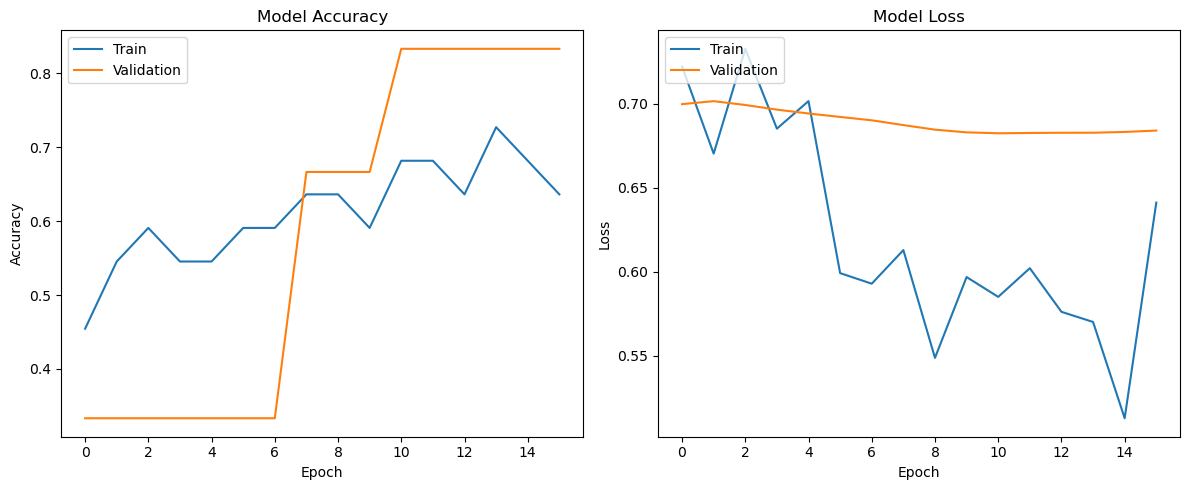

In [26]:
# Build a Multi-Input Deep Learning Model using Keras Functional API 

# Define the input layers for each data type
input_micro = Input(shape=(X_micro_train.shape[1],), name='microbiome_input')
input_metab = Input(shape=(X_metab_train.shape[1],), name='metabolome_input')

# Microbiome Branch 
# This branch processes the microbiome data
x1 = Dense(256, activation='relu')(input_micro)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Model(inputs=input_micro, outputs=x1) # This defines the microbiome sub-model

# Metabolome Branch 
# This branch processes the metabolome data
x2 = Dense(128, activation='relu')(input_metab)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Model(inputs=input_metab, outputs=x2) # This defines the metabolome sub-model

# Concatenate the branches 
# The outputs of the two branches are combined
combined = Concatenate()([x1.output, x2.output])

# Fully Connected Head 
# These layers process the combined data
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(64, activation='relu')(z)
output = Dense(1, activation='sigmoid', name='final_output')(z) # Binary classification output

# Create and Compile the Model 
# The final model takes two inputs and produces one output
multi_input_model = Model(inputs=[x1.input, x2.input], outputs=output)

multi_input_model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'AUC'])

# Print the model summary to see the architecture
multi_input_model.summary()

# Train the Model
history = multi_input_model.fit(
    [X_micro_train, X_metab_train],
    y_train_dl,
    epochs=50,
    batch_size=16,
    validation_split=0.2, # Use part of the training data for validation
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate the Model on the Test Set 
print("\n Evaluating the multi-input model on the test set ")
loss, accuracy, auc = multi_input_model.evaluate([X_micro_test, X_metab_test], y_test_dl)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# Plot Training History 
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## 🕐 Hands-on 3: Integrated Workflow — From Data to Insights
### 📋 Objectives:
- Build an **end-to-end workflow** from raw data → preprocessing → ML/DL models.
- Combine microbiome, omics, and environmental data.
- Derive interpretable **biological insights** relevant to aquaculture.

### ⚙️ Example Workflow Steps:
1. Raw data QC and normalization
2. Feature selection or dimensionality reduction
3. Model training and validation
4. Post-hoc interpretation and visualization

In [ ]:
# Example: Integrated pipeline pseudocode
# Step 1: Preprocess data
# Step 2: Train model
# Step 3: Evaluate results
# Step 4: Visualize findings

# Placeholder for pipeline code

### 📚 Suggested Reading & Resources
- [QIIME 2 16S Amplicon Pipeline](https://library.qiime2.org/quickstart/amplicon)
- [QIIME 2 - MOSHPIT Whole Metagenome Pipeline](https://library.qiime2.org/quickstart/moshpit)
- [QIIME 2 Machine Learning Plugin](https://docs.qiime2.org/)
- [Meta-CAMP - MetaSUB Whole Metagenome Analysis Pipeline](https://github.com/Meta-CAMP)
- [scikit-learn documentation](https://scikit-learn.org/stable/)
- [TensorFlow tutorials](https://www.tensorflow.org/tutorials)
- [PyTorch tutorials](https://pytorch.org/tutorials/)
- Example datasets: [EBI Metagenomics](https://www.ebi.ac.uk/metagenomics/)

**References**
1. Mazzella, V., Dell’Anno, A., Etxebarría, N., González-Gaya, B., Nuzzo, G., Fontana, A., & Núñez-Pons, L. (2024). High microbiome and metabolome diversification in coexisting sponges with different bio-ecological traits. Communications Biology, 7(1), 422.